# QCBM-based Path Simulation
Based on papers: https://arxiv.org/pdf/2204.06150, https://arxiv.org/html/2405.11795v1#Sx2.F4


In [2]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


total_qubits = 10
layers = 3
dev = qml.device("default.qubit", wires=total_qubits)


def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly Ansatz."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid Ansatz: Progressive entanglement """
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement ansatz"""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement ansatz with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))




# def rbs_gate(theta, wires):
#     """RBS gate."""
#     qml.RY(theta, wires=wires[0])
#     qml.CNOT(wires=wires)
#     qml.RY(-theta, wires=wires[0])
#     qml.CNOT(wires=wires)

# def pyramid_ansatz(params):
#     """Pyramid ansatz using RBS gates."""
#     qubits = params.shape[1]  
#     for l in range(params.shape[0]):  
#         step = 1
#         while step < qubits:
#             for i in range(0, qubits - step, 2 * step):
#                 rbs_gate(params[l, i, 0], wires=[i, i + step])
#             step *= 2  # Increase step size in powers of 2
#     return qml.probs(wires=range(qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return brick_ansatz(params)


In [3]:
def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))


def gaussian_kernel(x, y, sigma=1.0):
    return pnp.exp(-pnp.sum((x - y) ** 2) / (2 * sigma ** 2))

def mmd(x, y, sigma=1.0):
    xx, yy, xy = 0, 0, 0
    for i in range(len(x)):
        for j in range(len(x)):
            xx += gaussian_kernel(x[i], x[j], sigma)
            yy += gaussian_kernel(y[i], y[j], sigma)
            xy += gaussian_kernel(x[i], y[j], sigma)
    return xx / (len(x) ** 2) + yy / (len(y) ** 2) - 2 * xy / (len(x) * len(y))





def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('Stoxx15_24.csv')


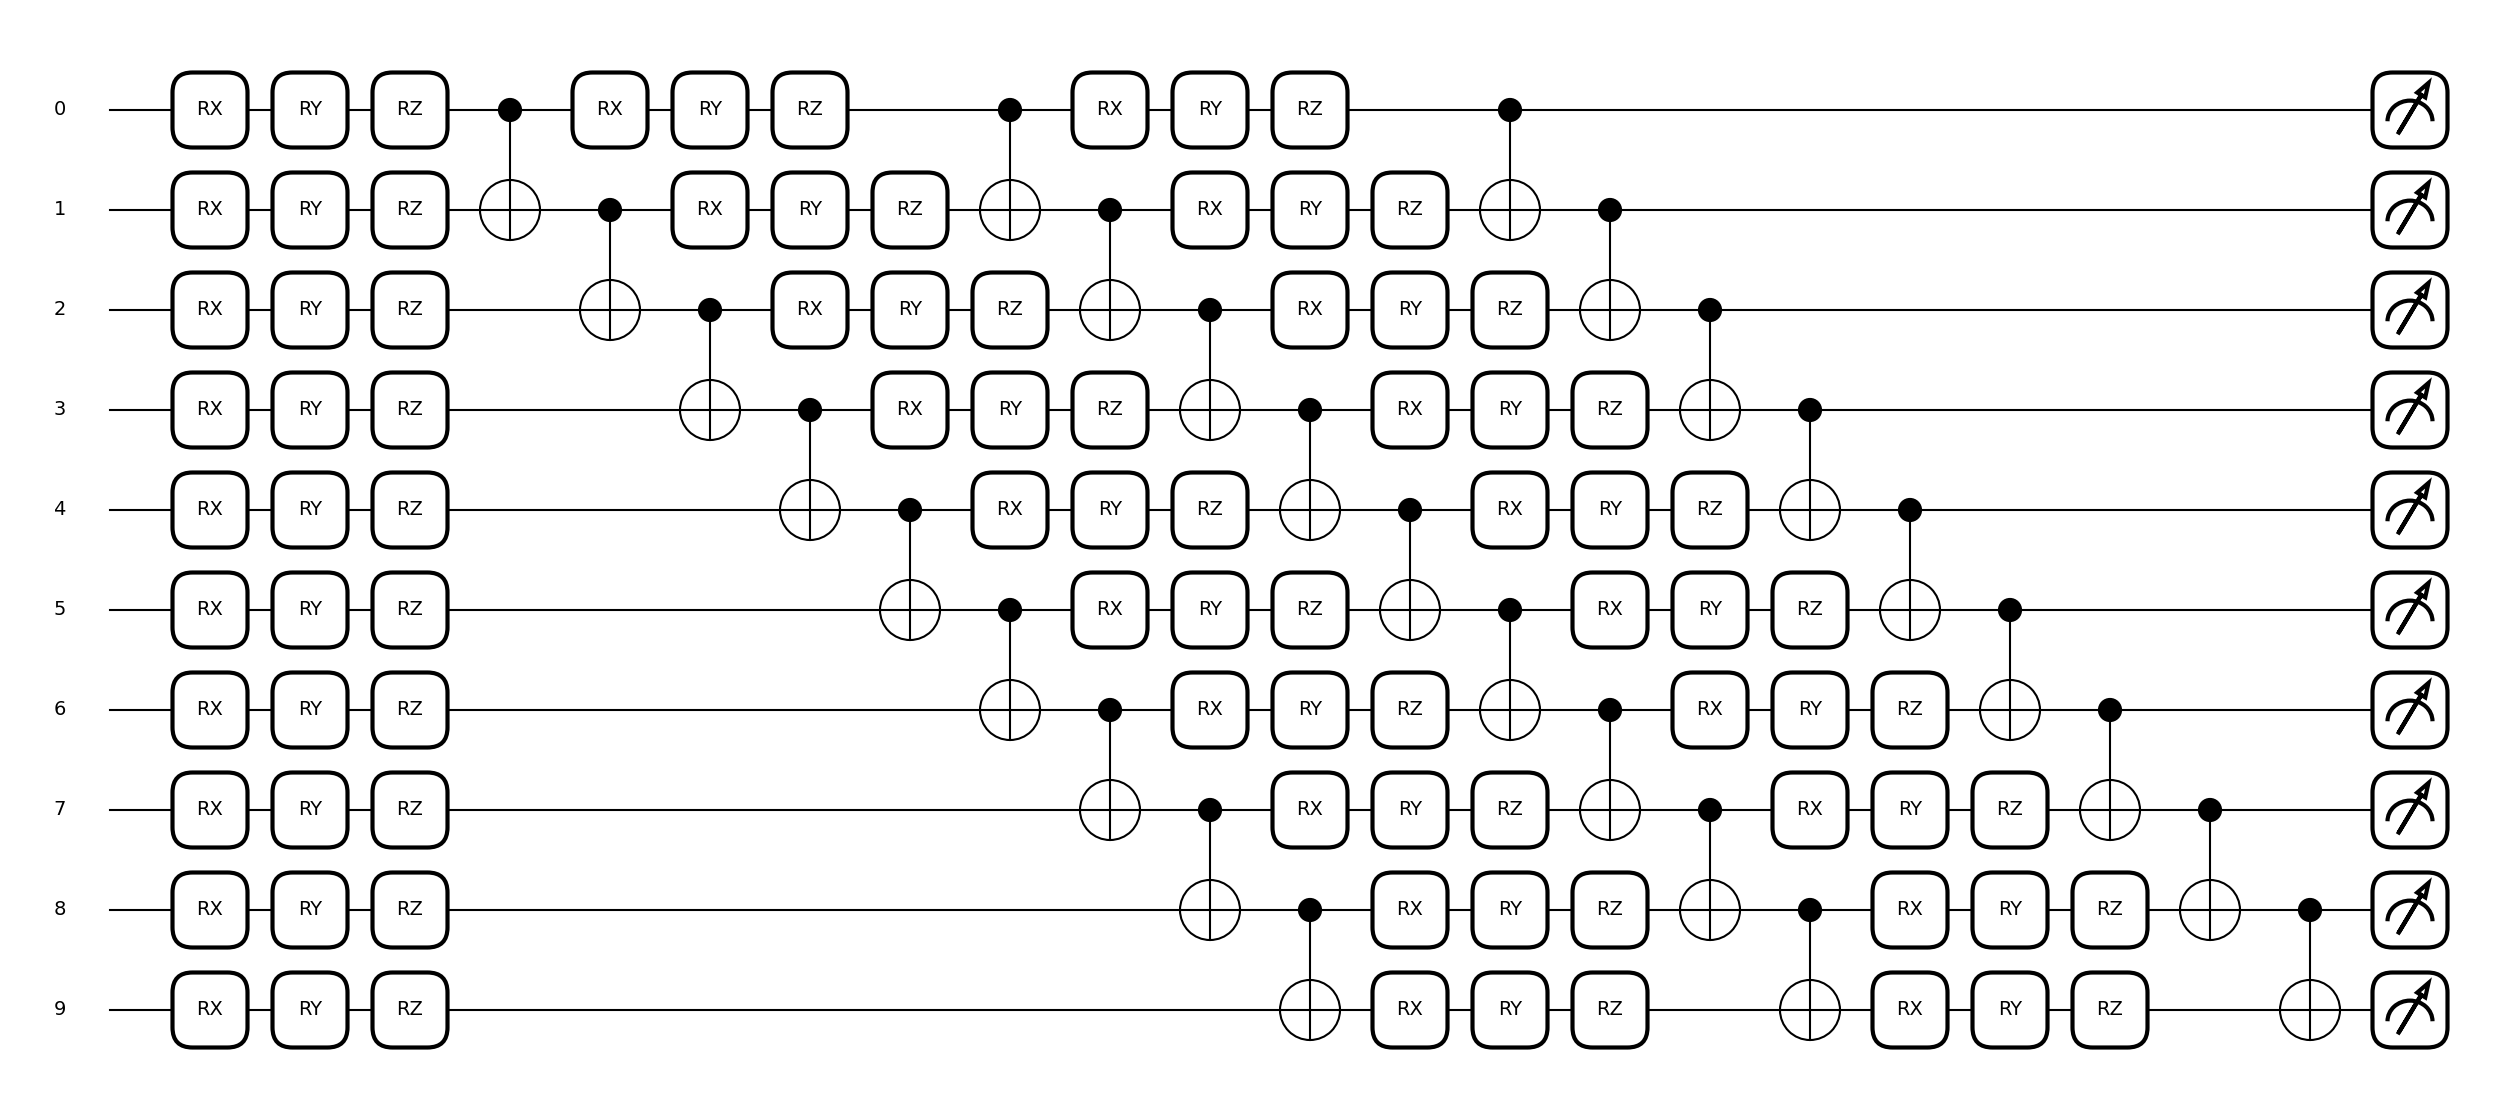

In [4]:
from pennylane import QNGOptimizer
opt = qml.AdamOptimizer(stepsize=0.1)
opt = qml.QNGOptimizer(stepsize=0.1)
#opt = qml.AdagradOptimizer(stepsize=0.1)
params = pnp.array(np.random.uniform(-np.pi, np.pi, (layers, total_qubits, 3)), requires_grad=True)

qml.draw_mpl(quantum_model)(params)
plt.show()


In [5]:
@qml.qnode(dev)
def cost(params):
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

# @qml.qnode(dev)
# def mse_cost(params):
#     quantum_probs = quantum_model(params)
#     empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
#     return np.sum((empirical_probs - quantum_probs) ** 2)


In [6]:
steps_training = 50

# for i in range(steps_training):
#     params = opt.step(mse_cost, params)
#     if i % 5 == 0:
#         print(f"Step {i}: Cost = {cost(params)}")

qng_cost = []

def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.9999

  for i in range(steps):
      params = opt.step(cost, params)
      new_cost = cost(params)
      qng_cost.append(new_cost)

      if np.round(old_cost, 4) == np.round(new_cost, 4):
          break
      else:
          old_cost = new_cost
  print("QNG: Cost after step {:5d}: {: .4f}".format(i + 1, new_cost))
  return params
     

# print("Final parameters:", params)
# print("Final cost:", cost(params))

params_momentum_qng = qng_session(params)

def save_params(params, file_path):
    params_df = pd.DataFrame(params.numpy().reshape(-1, 3), columns=["Theta", "Phi", "Lambda"])
    params_df.to_csv(file_path, index=False)

save_params(params, 'params.csv')


def load_params(file_path):
    params_df = pd.read_csv(file_path)
    return pnp.array(params_df.values).reshape(layers, total_qubits, 3)

def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]

QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.

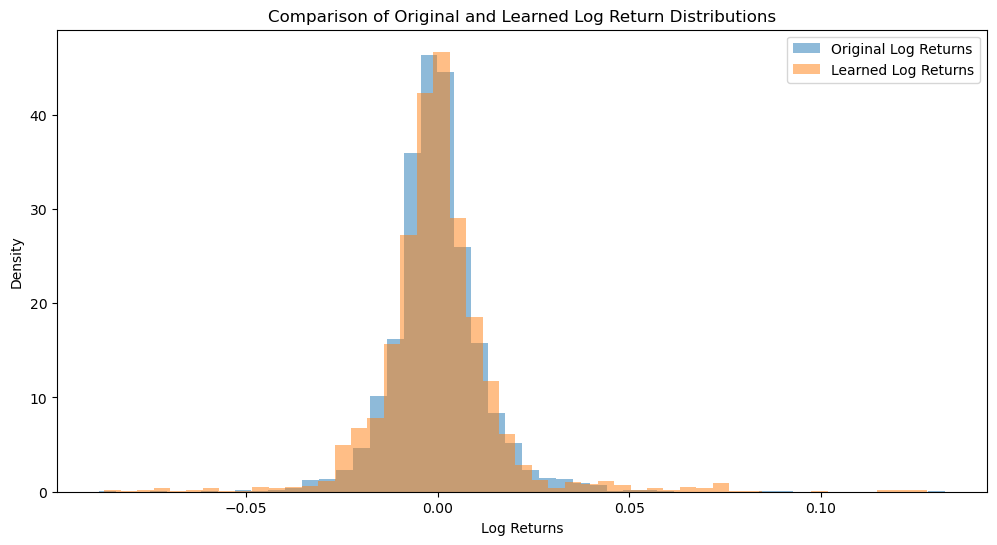

In [ ]:
synthetic_log_returns = generate_synthetic_log_returns(load_params('params.csv'), bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

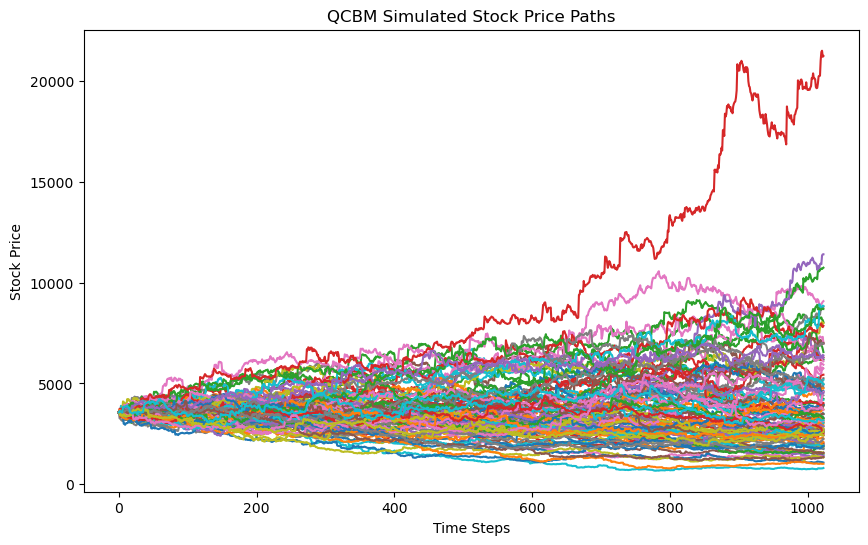

In [ ]:
def simulate_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 3564.63  # Starting value
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

# Propagate the learned process
def propagate_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


num_paths = 100
steps = 256*4
paths = propagate_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

original_distances = pairwise_distances(log_returns.reshape(-1, 1))
generated_distances = pairwise_distances(synthetic_log_returns.reshape(-1, 1))

mds = MDS(n_components=2, dissimilarity='precomputed')
original_mds = mds.fit_transform(original_distances)
generated_mds = mds.fit_transform(generated_distances)

plt.figure(figsize=(12, 6))
plt.scatter(original_mds[:, 0], original_mds[:, 1], label='Original Data')
plt.scatter(generated_mds[:, 0], generated_mds[:, 1], label='Generated Data')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Embedding of Original and Generated Data')
plt.legend()

KeyboardInterrupt: 

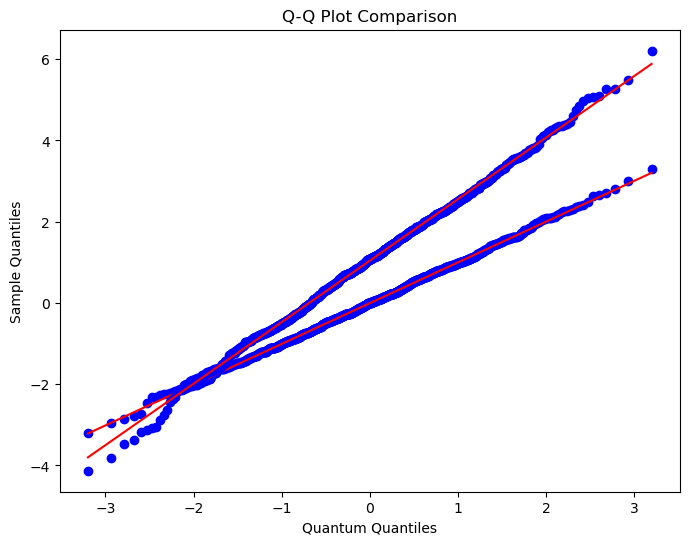

In [ ]:
import scipy.stats as stats

real_data = np.random.normal(loc=0, scale=1, size=1000)
quantum_generated_data = np.random.normal(loc=1, scale=1.5, size=1000)

plt.figure(figsize=(8, 6))
stats.probplot(real_data, dist="norm", plot=plt)
stats.probplot(quantum_generated_data, dist="norm", plot=plt)

plt.xlabel('Quantum Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot Comparison')
plt.show()

Variance of original log returns: 0.0001447396421013773
Variance of learned log returns: 0.00014289580314618119
ACF of original log returns: -0.01821758528597337
ACF of learned log returns: 0.02303917528644966


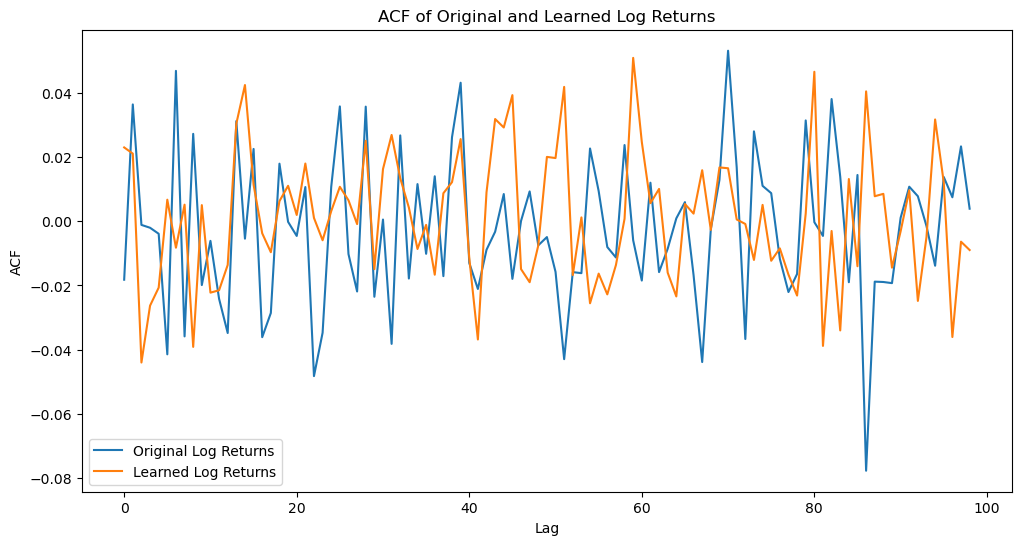

In [ ]:
import statsmodels.api as sm

def compute_variance(params, bins, steps=100):
    return np.var(generate_synthetic_log_returns(params, bins, steps))

print(f"Variance of original log returns: {np.var(log_returns)}")
print(f"Variance of learned log returns: {compute_variance(params, bins)}")

# compute the ACF of the quantum log returns
def compute_acf(data, lag=1):
    return np.corrcoef(data[:-lag], data[lag:])[0, 1]

print(f"ACF of original log returns: {compute_acf(log_returns)}")
print(f"ACF of learned log returns: {compute_acf(synthetic_log_returns)}")

plt.figure(figsize=(12, 6))
plt.plot([compute_acf(log_returns, lag) for lag in range(1, 100)], label='Original Log Returns')
plt.plot([compute_acf(synthetic_log_returns, lag) for lag in range(1, 100)], label='Learned Log Returns')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('ACF of Original and Learned Log Returns')
plt.legend()
plt.show()




<Figure size 1200x600 with 0 Axes>

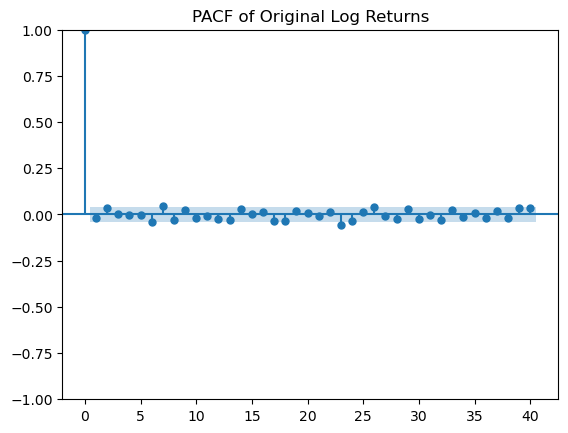

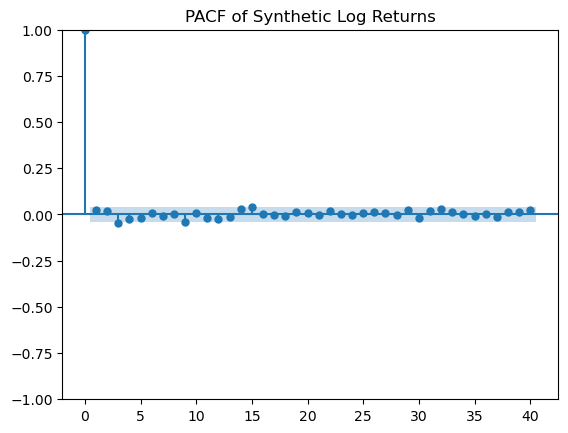

In [ ]:
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(log_returns, lags=40, alpha=0.05, title='PACF of Original Log Returns')
sm.graphics.tsa.plot_pacf(synthetic_log_returns, lags=40, alpha=0.05, title='PACF of Synthetic Log Returns')
plt.show()

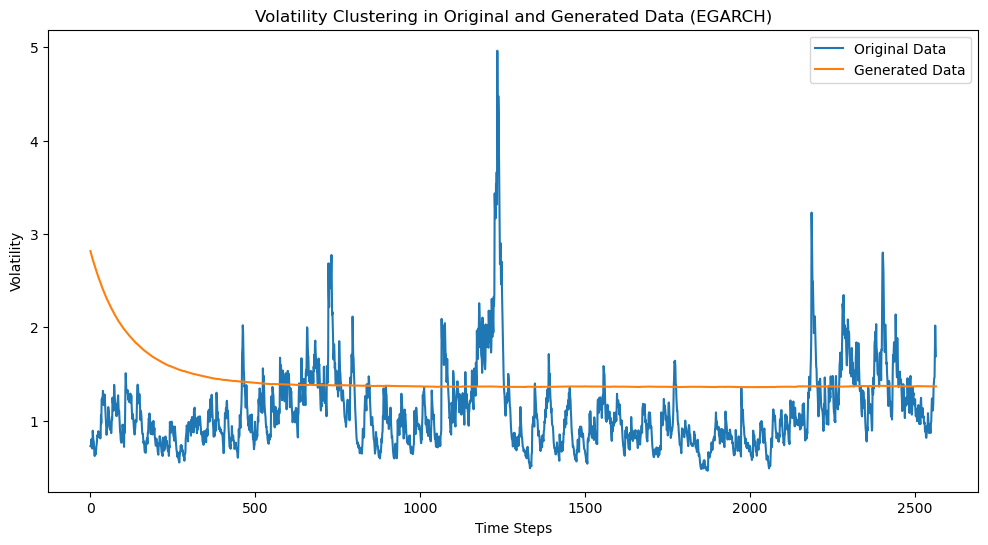

In [ ]:
import arch
import matplotlib.pyplot as plt

# Rescale log returns
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100

# Fit EGARCH(1,1) model to the rescaled original log returns
original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility

# Fit EGARCH(1,1) model to the rescaled synthetic log returns
synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

# Plot the volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Generated Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Original and Generated Data (EGARCH)')
plt.legend()
plt.show()

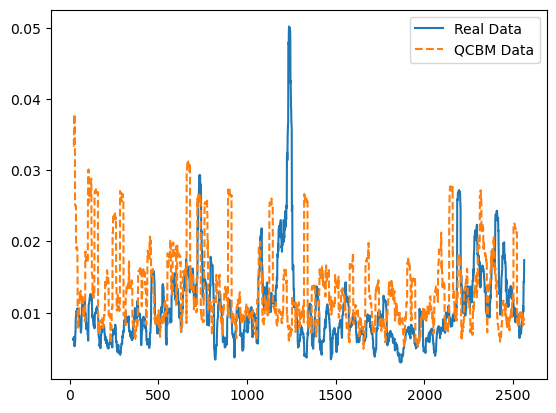

In [ ]:
import pandas as pd

def rolling_volatility(log_returns, window=20):
    return pd.Series(log_returns).rolling(window).std()

vol_real = rolling_volatility(log_returns)
vol_qcbm = rolling_volatility(synthetic_log_returns)

vol_real.plot(label="Real Data")
vol_qcbm.plot(label="QCBM Data", linestyle="dashed")
plt.legend()
plt.show()


In [ ]:
from scipy.stats import kurtosis

print(f"Kurtosis (Real Data): {kurtosis(log_returns)}")
print(f"Kurtosis (QCBM Data): {kurtosis(synthetic_log_returns)}")


Kurtosis (Real Data): 11.333142461871402
Kurtosis (QCBM Data): 16.664624275430402


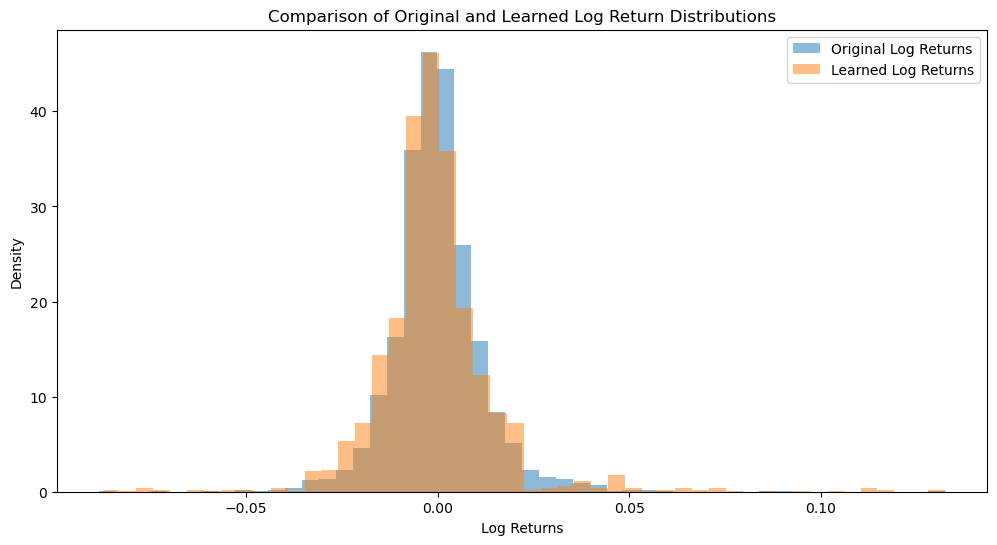

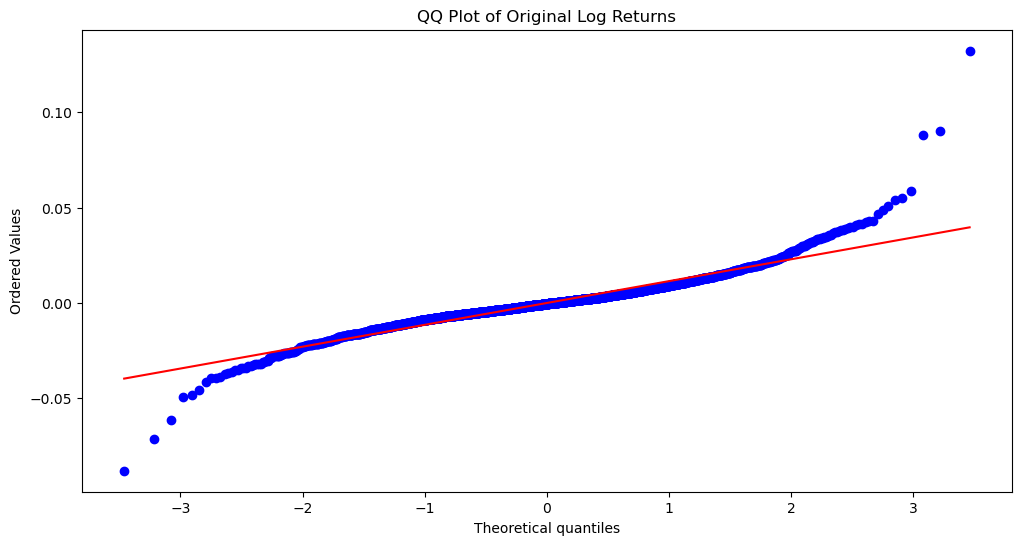

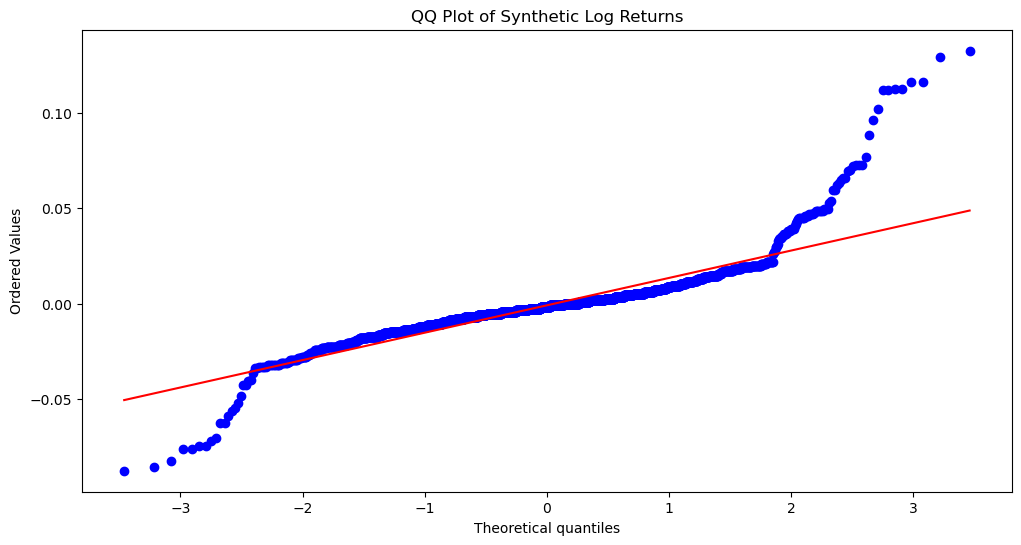

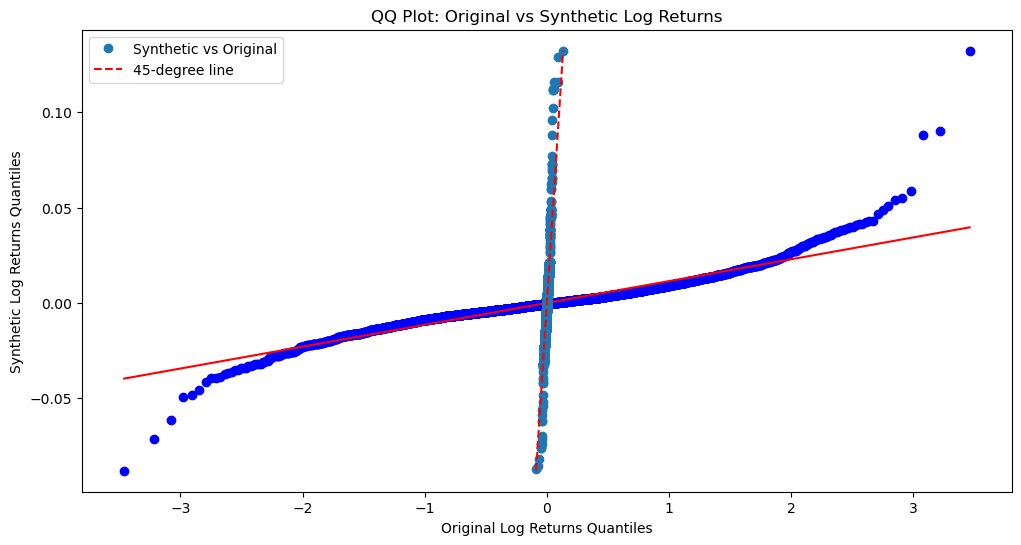

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate synthetic log returns
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

# Plot histograms of original and synthetic log returns
plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

# QQ plot to compare the tails of the distributions
plt.figure(figsize=(12, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Original Log Returns')
plt.show()

plt.figure(figsize=(12, 6))
stats.probplot(synthetic_log_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Synthetic Log Returns')
plt.show()

# QQ plot to compare original and synthetic log returns directly
plt.figure(figsize=(12, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.plot(sorted(log_returns), sorted(synthetic_log_returns), 'o', label='Synthetic vs Original')
plt.plot([min(log_returns), max(log_returns)], [min(log_returns), max(log_returns)], 'r--', label='45-degree line')
plt.xlabel('Original Log Returns Quantiles')
plt.ylabel('Synthetic Log Returns Quantiles')
plt.title('QQ Plot: Original vs Synthetic Log Returns')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

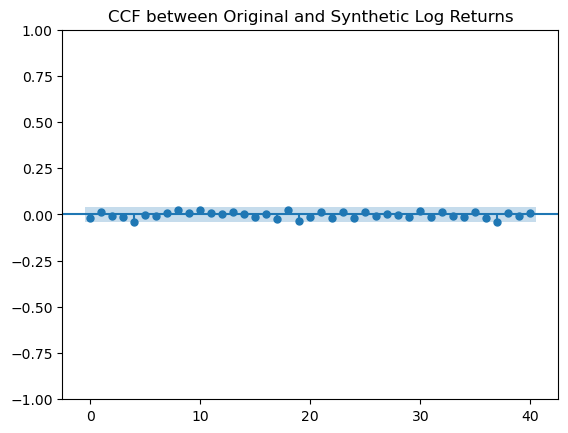

In [ ]:
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_ccf(log_returns, synthetic_log_returns, lags=40, alpha=0.05, title='CCF between Original and Synthetic Log Returns')
plt.show()

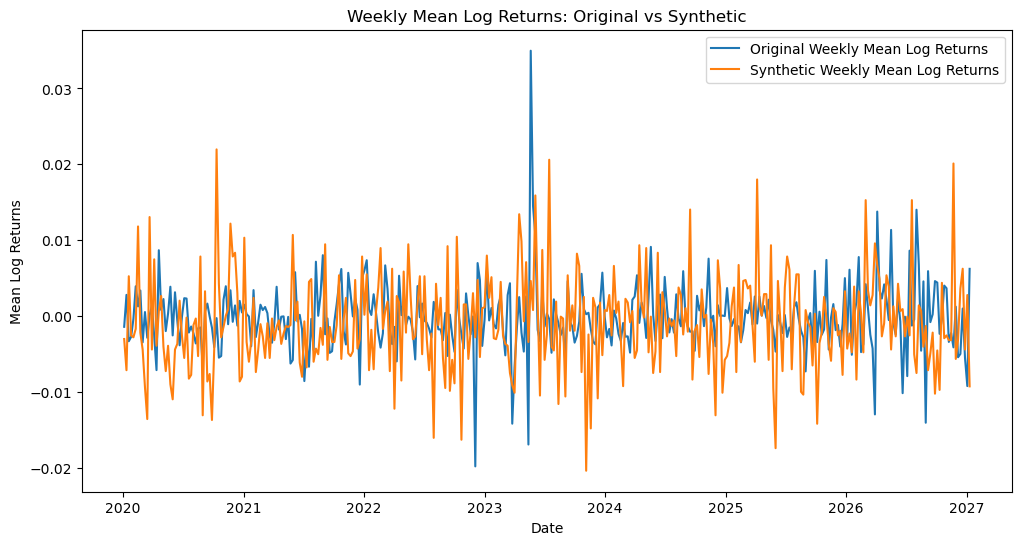

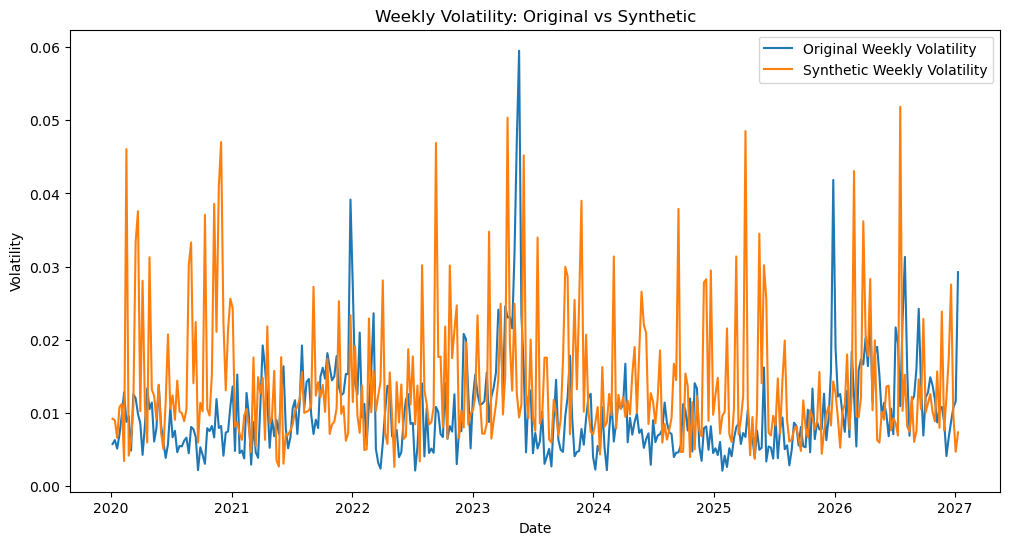

<Figure size 1200x600 with 0 Axes>

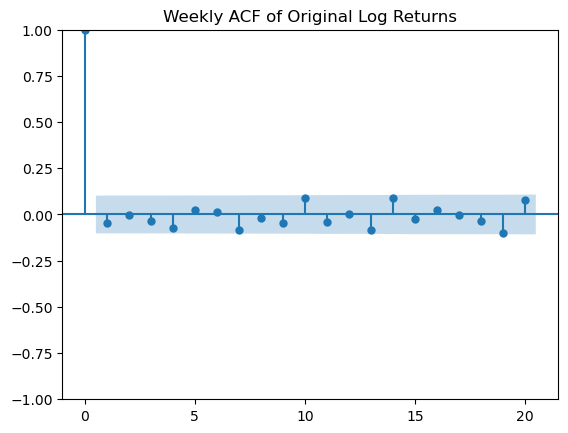

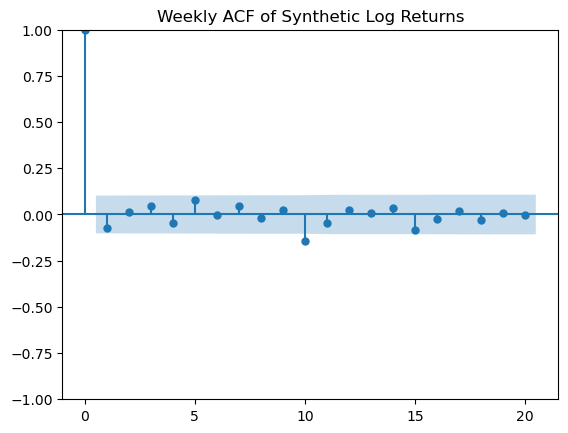

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate synthetic log returns
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

# Create a date range for the log returns
dates = pd.date_range(start='2020-01-01', periods=len(log_returns), freq='D')

# Create DataFrames for original and synthetic log returns
original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)

# Resample to weekly frequency and calculate mean log returns
original_weekly = original_df.resample('W').mean()
synthetic_weekly = synthetic_df.resample('W').mean()

# Plot weekly mean log returns
plt.figure(figsize=(12, 6))
plt.plot(original_weekly, label='Original Weekly Mean Log Returns')
plt.plot(synthetic_weekly, label='Synthetic Weekly Mean Log Returns')
plt.xlabel('Date')
plt.ylabel('Mean Log Returns')
plt.title('Weekly Mean Log Returns: Original vs Synthetic')
plt.legend()
plt.show()

# Calculate weekly volatility
original_weekly_volatility = original_df.resample('W').std()
synthetic_weekly_volatility = synthetic_df.resample('W').std()

# Plot weekly volatility
plt.figure(figsize=(12, 6))
plt.plot(original_weekly_volatility, label='Original Weekly Volatility')
plt.plot(synthetic_weekly_volatility, label='Synthetic Weekly Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Weekly Volatility: Original vs Synthetic')
plt.legend()
plt.show()

# Weekly autocorrelation
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(original_weekly, lags=20, alpha=0.05, title='Weekly ACF of Original Log Returns')
sm.graphics.tsa.plot_acf(synthetic_weekly, lags=20, alpha=0.05, title='Weekly ACF of Synthetic Log Returns')
plt.show()

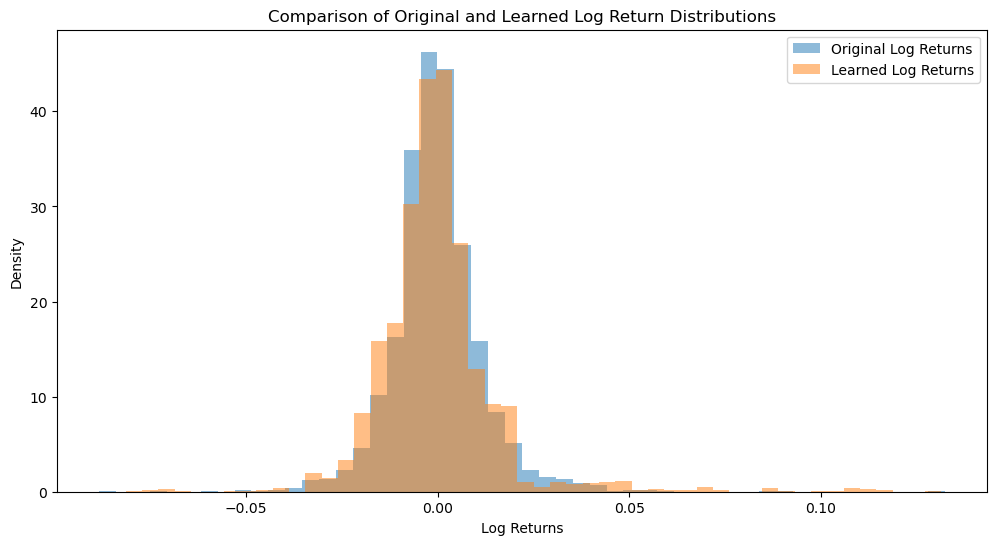

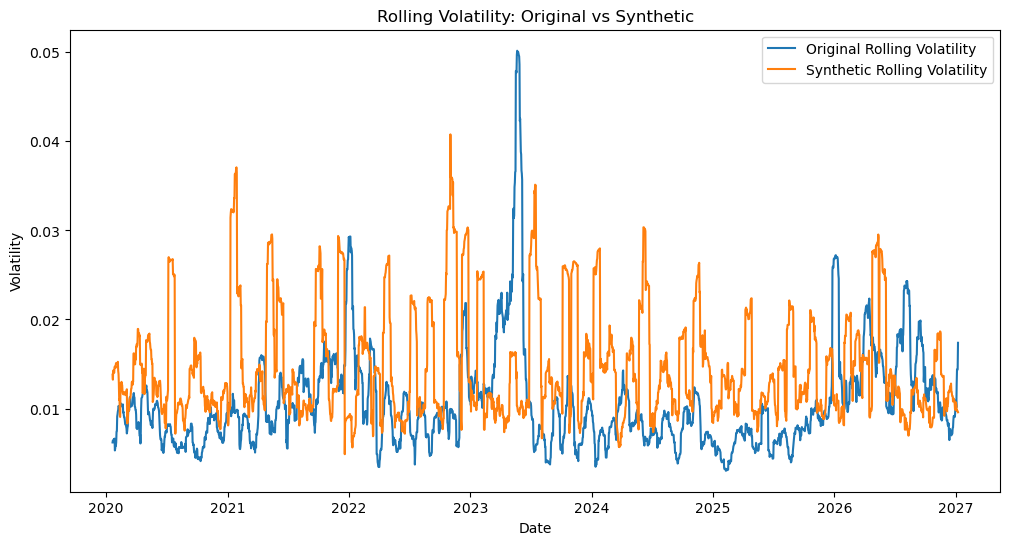

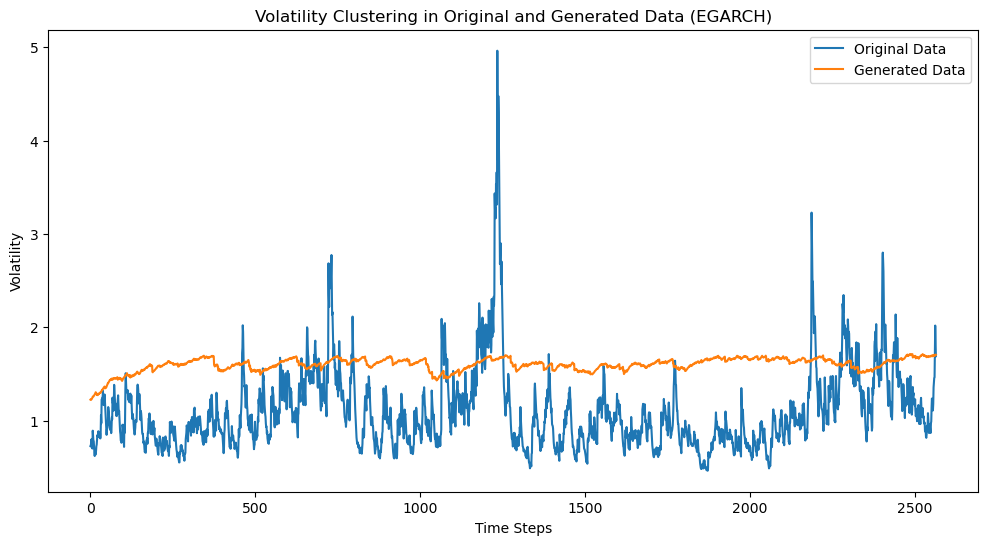

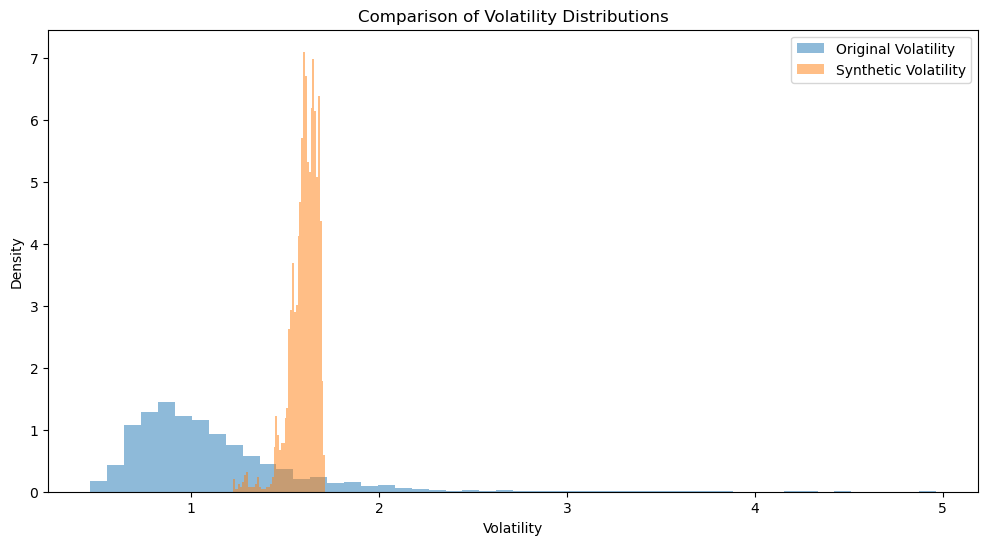

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch
import statsmodels.api as sm

# Generate synthetic log returns
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

# Plot histograms of original and synthetic log returns
plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

# Create DataFrames for original and synthetic log returns
dates = pd.date_range(start='2020-01-01', periods=len(log_returns), freq='D')
original_df = pd.DataFrame({'log_returns': log_returns}, index=dates)
synthetic_df = pd.DataFrame({'log_returns': synthetic_log_returns}, index=dates)

# Rolling volatility
window_size = 20
original_rolling_volatility = original_df['log_returns'].rolling(window=window_size).std()
synthetic_rolling_volatility = synthetic_df['log_returns'].rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(original_rolling_volatility, label='Original Rolling Volatility')
plt.plot(synthetic_rolling_volatility, label='Synthetic Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility: Original vs Synthetic')
plt.legend()
plt.show()

# Fit EGARCH(1,1) model to the original log returns
rescaled_log_returns = log_returns * 100
rescaled_synthetic_log_returns = synthetic_log_returns * 100

original_egarch = arch.arch_model(rescaled_log_returns, vol='EGARCH', p=1, q=1)
original_fit = original_egarch.fit(disp='off')
original_volatility = original_fit.conditional_volatility

# Fit EGARCH(1,1) model to the synthetic log returns
synthetic_egarch = arch.arch_model(rescaled_synthetic_log_returns, vol='EGARCH', p=1, q=1)
synthetic_fit = synthetic_egarch.fit(disp='off')
synthetic_volatility = synthetic_fit.conditional_volatility

# Plot the volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(original_volatility, label='Original Data')
plt.plot(synthetic_volatility, label='Generated Data')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.title('Volatility Clustering in Original and Generated Data (EGARCH)')
plt.legend()
plt.show()

# Volatility distribution
plt.figure(figsize=(12, 6))
plt.hist(original_volatility, bins=50, alpha=0.5, label='Original Volatility', density=True)
plt.hist(synthetic_volatility, bins=50, alpha=0.5, label='Synthetic Volatility', density=True)
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.title('Comparison of Volatility Distributions')
plt.legend()
plt.show()

Original Moments: Mean = -0.0002, Variance = 0.0001, Skewness = 0.8517, Kurtosis = 11.3331
Synthetic Moments: Mean = -0.0005, Variance = 0.0002, Skewness = 1.6273, Kurtosis = 12.7745


<Figure size 1200x600 with 0 Axes>

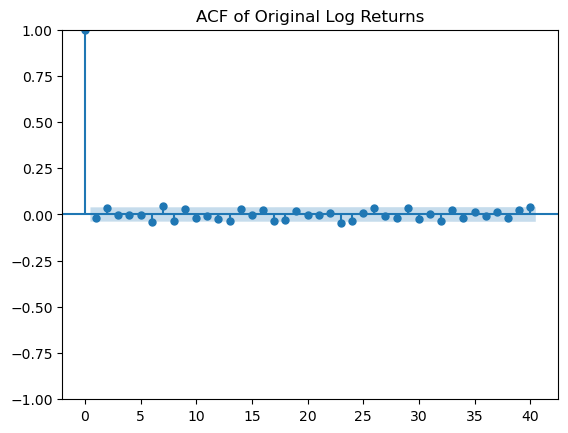

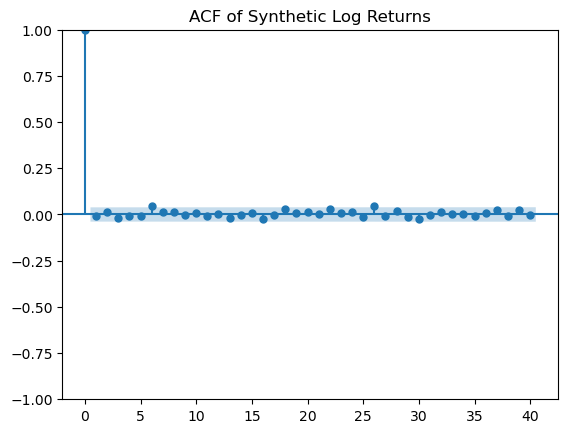

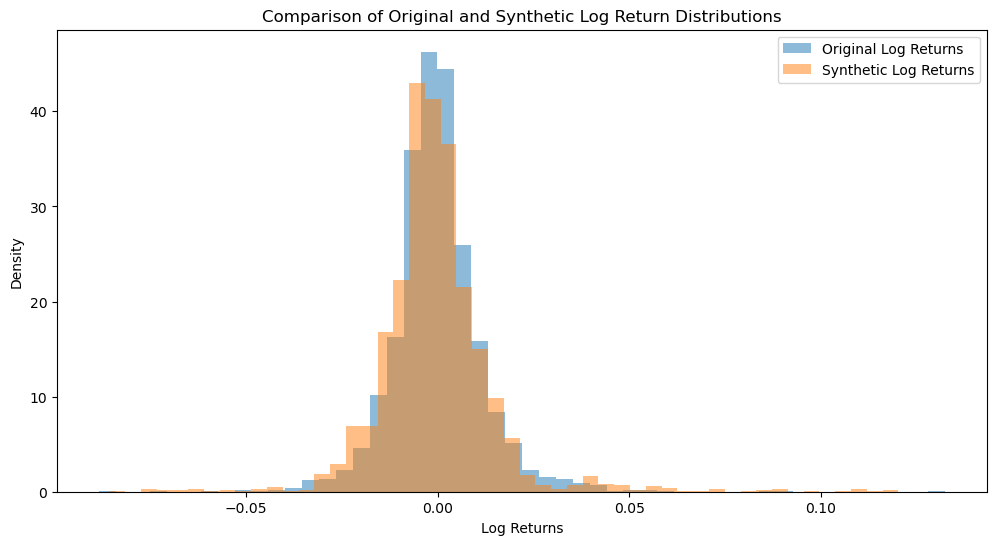

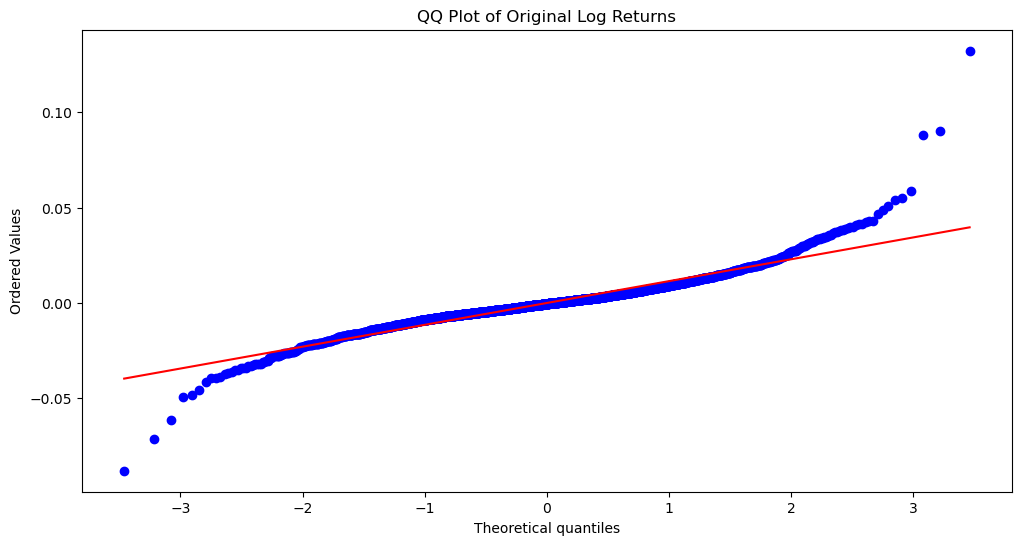

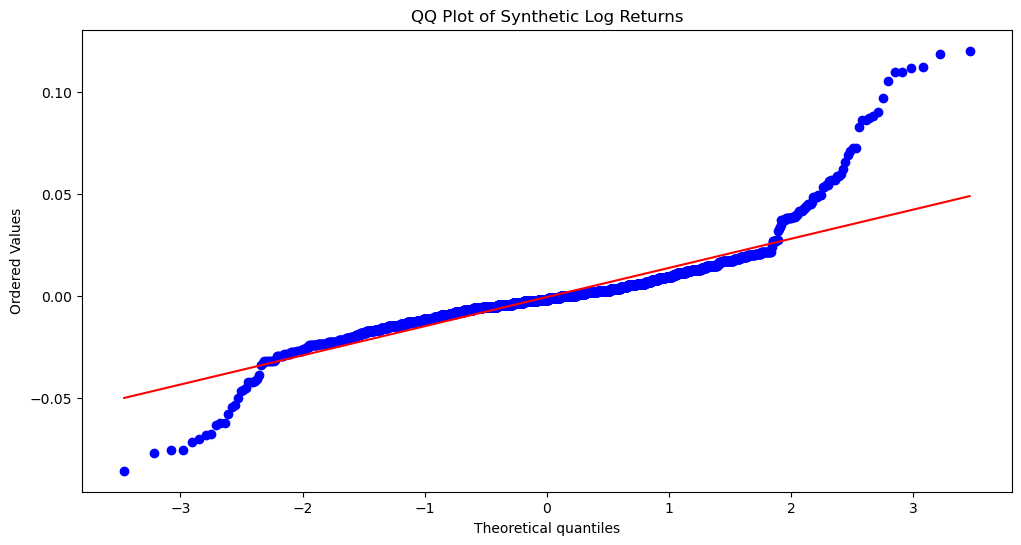

<Figure size 1200x600 with 0 Axes>

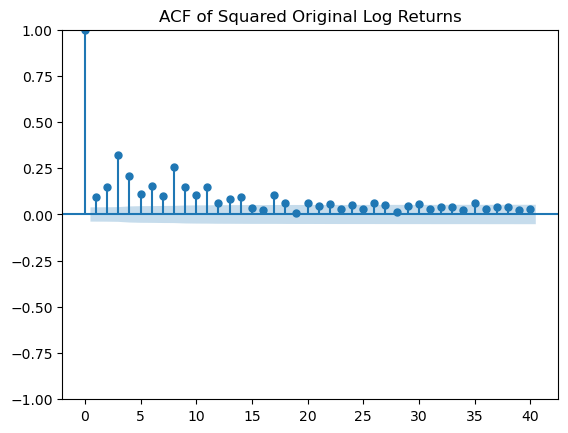

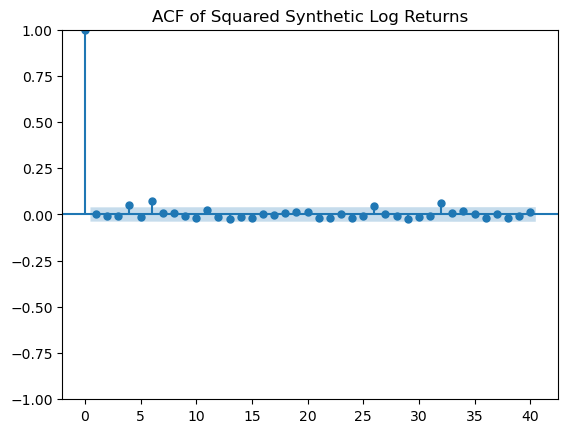

<Figure size 1200x600 with 0 Axes>

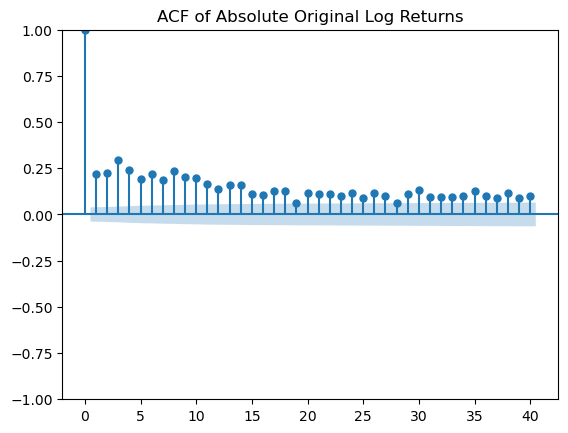

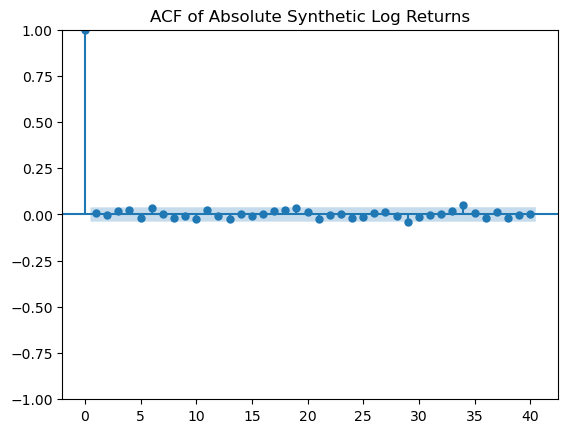

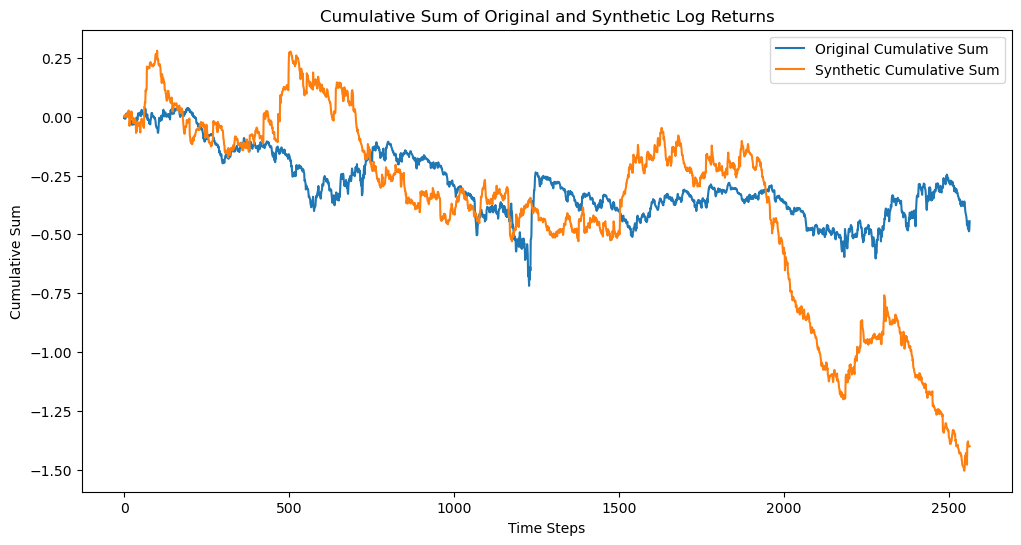

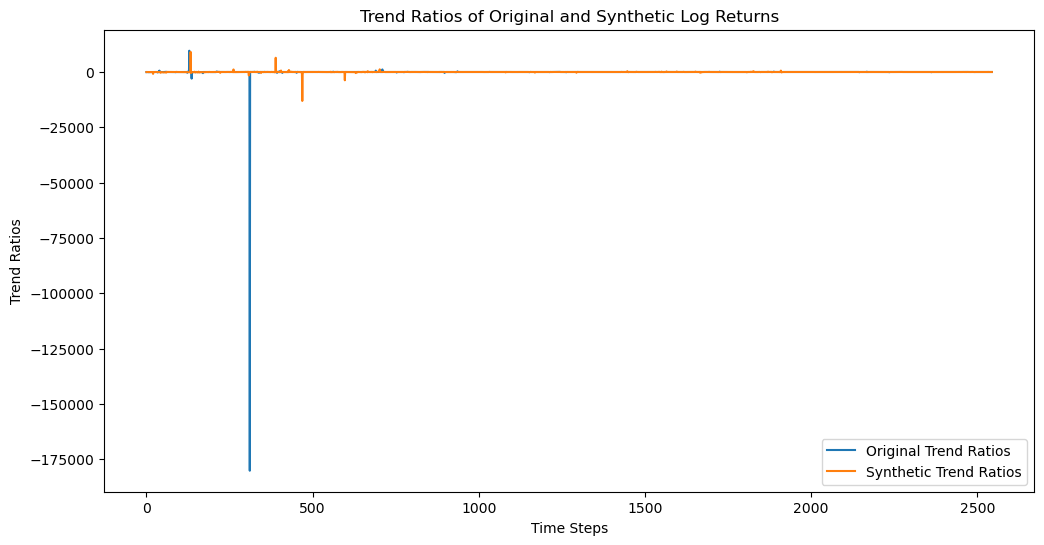

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Generate synthetic log returns
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

# Central Moments
def central_moments(data):
    mean = np.mean(data)
    variance = np.var(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    return mean, variance, skewness, kurtosis

original_moments = central_moments(log_returns)
synthetic_moments = central_moments(synthetic_log_returns)

print("Original Moments: Mean = {:.4f}, Variance = {:.4f}, Skewness = {:.4f}, Kurtosis = {:.4f}".format(*original_moments))
print("Synthetic Moments: Mean = {:.4f}, Variance = {:.4f}, Skewness = {:.4f}, Kurtosis = {:.4f}".format(*synthetic_moments))

# Autocorrelation
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(log_returns, lags=40, alpha=0.05, title='ACF of Original Log Returns')
sm.graphics.tsa.plot_acf(synthetic_log_returns, lags=40, alpha=0.05, title='ACF of Synthetic Log Returns')
plt.show()

# Heavy-Tailed Distribution
plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Synthetic Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Synthetic Log Return Distributions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Original Log Returns')
plt.show()

plt.figure(figsize=(12, 6))
stats.probplot(synthetic_log_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Synthetic Log Returns')
plt.show()

# Volatility Clustering
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(log_returns**2, lags=40, alpha=0.05, title='ACF of Squared Original Log Returns')
sm.graphics.tsa.plot_acf(synthetic_log_returns**2, lags=40, alpha=0.05, title='ACF of Squared Synthetic Log Returns')
plt.show()

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(np.abs(log_returns), lags=40, alpha=0.05, title='ACF of Absolute Original Log Returns')
sm.graphics.tsa.plot_acf(np.abs(synthetic_log_returns), lags=40, alpha=0.05, title='ACF of Absolute Synthetic Log Returns')
plt.show()

# Cumulative Sum
cumulative_sum_original = np.cumsum(log_returns)
cumulative_sum_synthetic = np.cumsum(synthetic_log_returns)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_sum_original, label='Original Cumulative Sum')
plt.plot(cumulative_sum_synthetic, label='Synthetic Cumulative Sum')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Original and Synthetic Log Returns')
plt.legend()
plt.show()

# Trend Ratios
def trend_ratios(cumulative_sum, lookback=20):
    trend_ratios = []
    for i in range(lookback, len(cumulative_sum)):
        trend = cumulative_sum[i] / cumulative_sum[i - lookback] - 1
        noise = np.mean([cumulative_sum[k] / cumulative_sum[k - 1] - 1 for k in range(i - lookback + 1, i + 1)])
        trend_ratios.append(trend / noise)
    return trend_ratios

trend_ratios_original = trend_ratios(cumulative_sum_original)
trend_ratios_synthetic = trend_ratios(cumulative_sum_synthetic)

plt.figure(figsize=(12, 6))
plt.plot(trend_ratios_original, label='Original Trend Ratios')
plt.plot(trend_ratios_synthetic, label='Synthetic Trend Ratios')
plt.xlabel('Time Steps')
plt.ylabel('Trend Ratios')
plt.title('Trend Ratios of Original and Synthetic Log Returns')
plt.legend()
plt.show()

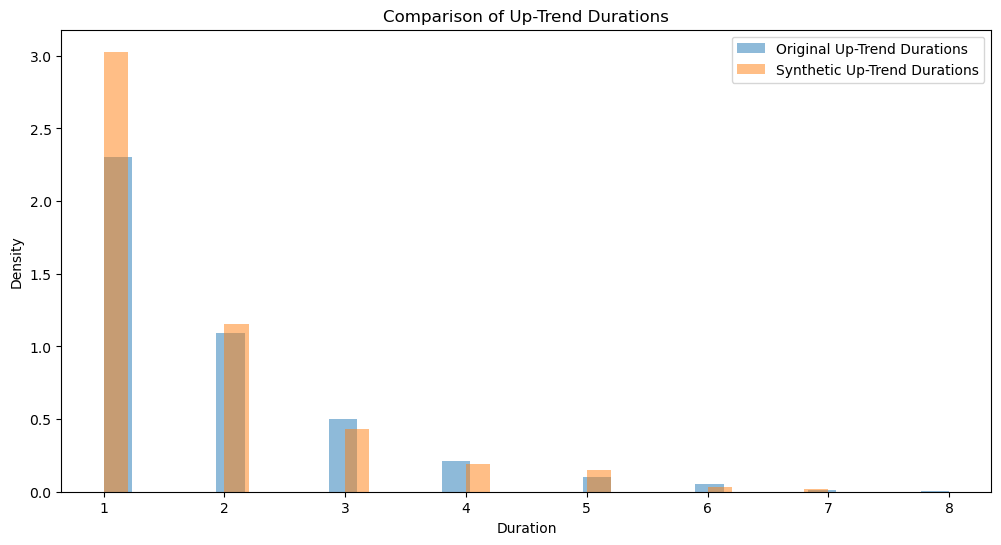

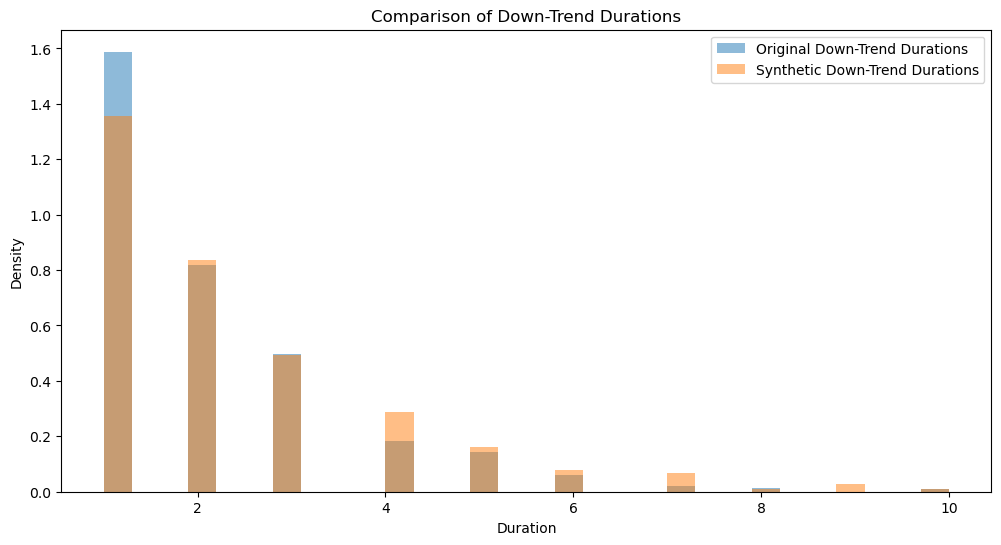

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic log returns
synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

def calculate_trend_durations(log_returns):
    up_trend_durations = []
    down_trend_durations = []
    current_trend_duration = 0
    current_trend = None

    for return_value in log_returns:
        if return_value > 0:
            if current_trend == 'up':
                current_trend_duration += 1
            else:
                if current_trend == 'down':
                    down_trend_durations.append(current_trend_duration)
                current_trend = 'up'
                current_trend_duration = 1
        elif return_value < 0:
            if current_trend == 'down':
                current_trend_duration += 1
            else:
                if current_trend == 'up':
                    up_trend_durations.append(current_trend_duration)
                current_trend = 'down'
                current_trend_duration = 1
        else:
            if current_trend == 'up':
                up_trend_durations.append(current_trend_duration)
            elif current_trend == 'down':
                down_trend_durations.append(current_trend_duration)
            current_trend = None
            current_trend_duration = 0

    # Append the last trend duration
    if current_trend == 'up':
        up_trend_durations.append(current_trend_duration)
    elif current_trend == 'down':
        down_trend_durations.append(current_trend_duration)

    return up_trend_durations, down_trend_durations

# Calculate trend durations for original and synthetic log returns
original_up_trend_durations, original_down_trend_durations = calculate_trend_durations(log_returns)
synthetic_up_trend_durations, synthetic_down_trend_durations = calculate_trend_durations(synthetic_log_returns)

# Plot histograms of trend durations
plt.figure(figsize=(12, 6))
plt.hist(original_up_trend_durations, bins=30, alpha=0.5, label='Original Up-Trend Durations', density=True)
plt.hist(synthetic_up_trend_durations, bins=30, alpha=0.5, label='Synthetic Up-Trend Durations', density=True)
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('Comparison of Up-Trend Durations')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(original_down_trend_durations, bins=30, alpha=0.5, label='Original Down-Trend Durations', density=True)
plt.hist(synthetic_down_trend_durations, bins=30, alpha=0.5, label='Synthetic Down-Trend Durations', density=True)
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('Comparison of Down-Trend Durations')
plt.legend()
plt.show()